In [85]:
# importing packages. See https://github.com/BasisResearch/collab-creatures for repo setup
import logging
import os
import time

import dill
import matplotlib.pyplot as plt
import pandas as pd

import collab2.foraging.toolkit as ft
from collab2.foraging.toolkit import dataObject, plot_predictor
from collab2.utils import find_repo_root

logging.basicConfig(format="%(message)s", level=logging.INFO)

root = find_repo_root()

# users can ignore smoke_test -- it's for automatic testing on GitHub,
# to make sure the notebook runs on future updates to the repository
smoke_test = "CI" in os.environ
frames = 150 if smoke_test else 300
frames_sps = 150 if smoke_test else 300
sampling_rate = 0.001 if smoke_test else 0.01
num_svi_iters = 100 if smoke_test else 1000
num_samples = 100 if smoke_test else 1000

notebook_starts = time.time()

## Data processing

In [2]:
ducks_raw = pd.read_csv(
    os.path.join(
        root,
        "data/foraging/central_park_birds_cleaned_2022/20221215122046189_-5_25_bone.avi.hand_checked_cleaned_df.csv",
    )
)
sparrows_raw = pd.read_csv(
    os.path.join(
        root,
        "data/foraging/central_park_birds_cleaned_2022/20221229124843603_n5_25_bone.avi.hand_checked_cleaned_df.csv",
    )
)

ducks_raw = ducks_raw.rename(columns={"bird": "forager"})
sparrows_raw = sparrows_raw.rename(columns={"bird": "forager"})

ducks_sub = ft.subset_frames_evenly_spaced(ducks_raw, frames)
ducks_sub = ft.rescale_to_grid(ducks_sub, 90)
ducks_object = dataObject(foragersDF=ducks_sub)

sps_sub = ft.subset_frames_evenly_spaced(sparrows_raw, frames_sps)
sps_sub = ft.rescale_to_grid(sps_sub, 90)
sps_object = dataObject(foragersDF=sps_sub)

original_frames: 1451
original_shape: (8867, 4)
resulting_frames: 300
resulting_shape: (1848, 4)
original_frames: 11550
original_shape: (22821, 4)
resulting_frames: 279
resulting_shape: (617, 4)


/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/utils.py:62: UserWarning: 
                    Missing frames encountered for forager 0, adding NaN fillers.
                    The default behavior of predictor/score generating functions is
                    to ignore foragers with missing positional data. To modify, see documentation of
                    `derive_predictors_and_scores` and `generate_local_windows`
                    
  warnings.warn(
/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/utils.py:62: UserWarning: 
                    Missing frames encountered for forager 1, adding NaN fillers.
                    The default behavior of predictor/score generating functions is
                    to ignore foragers with missing positional data. To modify, see documentation of
                    `derive_predictors_and_scores` and `generate_local_windows`
                    
  warnings.warn(
/home/rafal/s78projects/collab-creatures/col

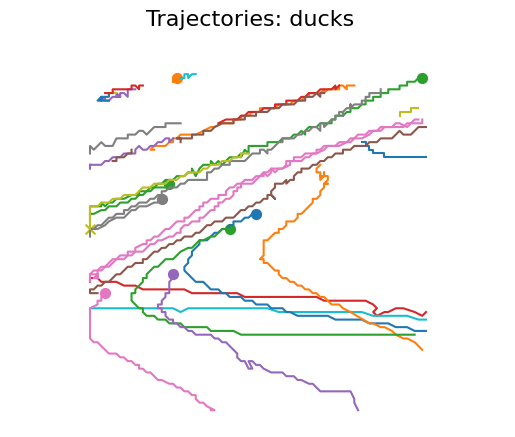

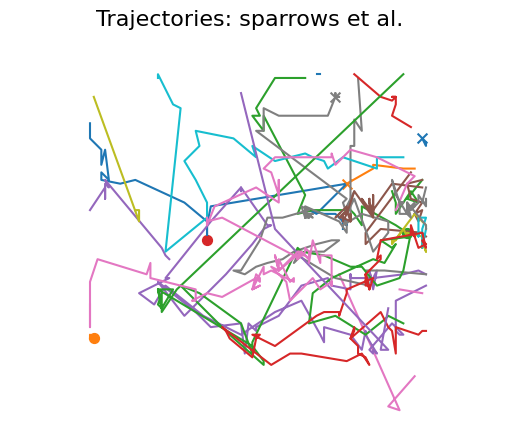

In [3]:
fig = ft.plot_trajectories(ducks_object.foragersDF, "ducks", legend=False)
# too many birds to show legend
fig.show()
path = os.path.join(root, "docs/figures/fig_bird_trajectories_ducks.png")
if not os.path.exists(path):
    plt.savefig(path, dpi=300)

plt = ft.plot_trajectories(sps_object.foragersDF, "sparrows et al.", legend=False)
plt.show()
path = os.path.join(root, "docs/figures/fig_bird_trajectories_sps.png")
if not os.path.exists(path):
    plt.savefig(path, dpi=300)

In [4]:
duck_distances_path = os.path.join(
    root, "docs/foraging/central-park-birds/duck_distances.pkl"
)
sps_distances_path = os.path.join(
    root, "docs/foraging/central-park-birds/sps_distances.pkl"
)

if not os.path.exists(duck_distances_path) or not os.path.exists(sps_distances_path):
    duck_distances = ft.foragers_to_forager_distances(obj=ducks_object)
    sps_distances = ft.foragers_to_forager_distances(obj=sps_object)

    with open(duck_distances_path, "wb") as f:
        dill.dump(duck_distances, f)

    with open(sps_distances_path, "wb") as f:
        dill.dump(sps_distances, f)

else:
    print("Loading precomputed distances.")
    with open(duck_distances_path, "rb") as f:
        duck_distances = dill.load(f)

    with open(sps_distances_path, "rb") as f:
        sps_distances = dill.load(f)

Loading precomputed distances.


In [5]:
fig = ft.plot_distances(duck_distances, "ducks")
fig.show()
path = os.path.join(root, "docs/figures/fig_distance_distribution_ducks.png")
if not os.path.exists(path):
    fig.write_image(path, scale=2)

fig = ft.plot_distances(sps_distances, "sparrows et al.")
fig.show()
path = os.path.join(root, "docs/figures/fig_distance_distribution_sps.png")
if not os.path.exists(path):
    fig.write_image(path, scale=2)

## Inference with a specific quantitative hypothesis

One thing we can now do is formulate a specific parametrized hypothesis about proximity preference and investigate what role the model assigns to the predictor this assigned. 
We do have more to say about how we could go about choosing the hypotheses, but we will postpone this discussion to another notebook. Say we pick one that we expect to work decently for ducks but not for sparrows, as follows:

In [ ]:
force = False  # to facilitate future modifications

# we will use the same parameters for both species


def derive_cp_predictors(data_object, rep, opt):
    window_size = 30
    sampling_fraction = 0.2

    score_kwargs = {
        "nextStep_sublinear_25": {
            "nonlinearity_exponent": 2.5
        },  # chosen to decrease nonlinearity in I/O relationship
    }

    predictor_kwargs = {
        "access": {
            "decay_factor": 0.9,
        },
        "proximity": {
            "interaction_length": 90,
            "optimal_distance": opt,
            "repulsion_radius": rep,
            "proximity_decay": 0.2,
        },
    }

    local_windows_kwargs = {
        "window_size": window_size,
        "sampling_fraction": sampling_fraction,
        "skip_incomplete_frames": False,
    }

    object_derived_DF = ft.derive_predictors_and_scores(
        data_object,
        local_windows_kwargs,
        predictor_kwargs=predictor_kwargs,
        score_kwargs=score_kwargs,
        dropna=True,
        add_scaled_values=True,
    )

    return object_derived_DF


ducks_derivedDF = derive_cp_predictors(ducks_object, rep=2, opt=7)
sps_derivedDF = derive_cp_predictors(sps_object, rep=2, opt=7)

2024-10-18 10:29:41,405 - access completed in 2.75 seconds.


/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/visualization.py:100: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



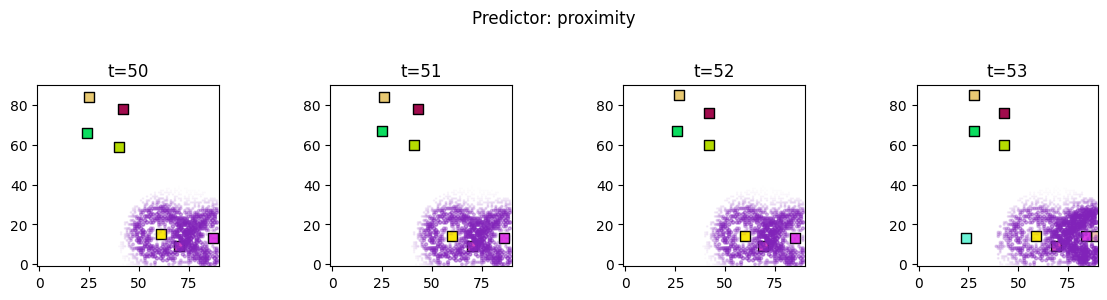

In [74]:
predictor_name = "proximity"
plot_predictor(
    ducks_object.foragers,
    ducks_object.derived_quantities[predictor_name],
    predictor_name=predictor_name,
    time=range(50, 54),
    grid_size=90,
    size_multiplier=10,
    random_state=99,
    forager_position_indices=list(range(29)),
    forager_predictor_indices=[2],
)

/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/visualization.py:100: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



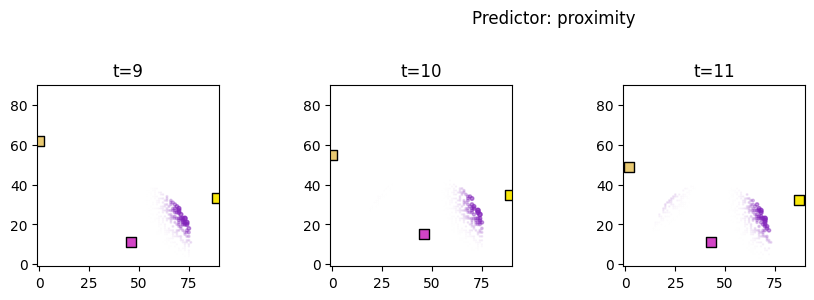

In [75]:
predictor_name = "proximity"
plot_predictor(
    sps_object.foragers,
    sps_object.derived_quantities[predictor_name],
    predictor_name=predictor_name,
    time=range(9, 12),
    grid_size=90,
    size_multiplier=10,
    random_state=99,
    forager_position_indices=list(range(28)),
    forager_predictor_indices=[2],
)

In [77]:
predictors = ["access", "proximity"]
outcome_vars = ["nextStep_sublinear_35"]

ducks_predictor_dict, ducks_outcome_dict = ft.prep_DF_data_for_inference(
    ducks_derivedDF,
    predictors,
    outcome_vars,
    subsample_rate=0.1,
)

sps_predictor_dict, sps_outcome_dict = ft.prep_DF_data_for_inference(
    sps_derivedDF,
    predictors,
    outcome_vars,
    subsample_rate=0.1,
)

ft.visualise_forager_predictors(
    predictors=[
        ducks_predictor_dict["proximity"],
    ],
    predictor_names=["proximity: ducks"],
    outcome_name=outcome_vars[0],
    outcome=ducks_outcome_dict[outcome_vars[0]],
    sampling_rate=0.3,
)

ft.visualise_forager_predictors(
    predictors=[
        sps_predictor_dict["proximity"],
    ],
    predictor_names=["proximity: sparrows et al."],
    outcome_name=outcome_vars[0],
    outcome=sps_outcome_dict[outcome_vars[0]],
    sampling_rate=0.3,
)

Sample size: 16863
Sample size: 16863
Sample size: 5992
Sample size: 5992


In [78]:
ducks_model = ft.HeteroskedasticLinear(ducks_predictor_dict, ducks_outcome_dict)

ducks_outcome = ft.get_samples(
    model=ducks_model,
    predictors=ducks_predictor_dict,
    outcome=ducks_outcome_dict,
    num_svi_iters=num_svi_iters,
    num_samples=num_samples,
    plot=False,
    verbose=False,
)

2024-10-18 10:22:06,302 - Starting SVI inference with 1000 iterations.


[iteration 0200] loss: 33994.8867
[iteration 0400] loss: 34037.6094
[iteration 0600] loss: 33948.8008
[iteration 0800] loss: 33936.3320


2024-10-18 10:22:11,110 - SVI inference completed in 4.80 seconds.


[iteration 1000] loss: 33951.2109
Coefficient marginals:
Site: weight_continuous_access_nextStep_sublinear_35
      mean       std        5%       25%       50%       75%       95%
0  0.48382  0.044841  0.407302  0.454369  0.483555  0.511911  0.559628 

Site: weight_continuous_proximity_nextStep_sublinear_35
       mean       std       5%       25%       50%      75%       95%
0  0.199283  0.017652  0.17054  0.187359  0.199734  0.21148  0.227613 



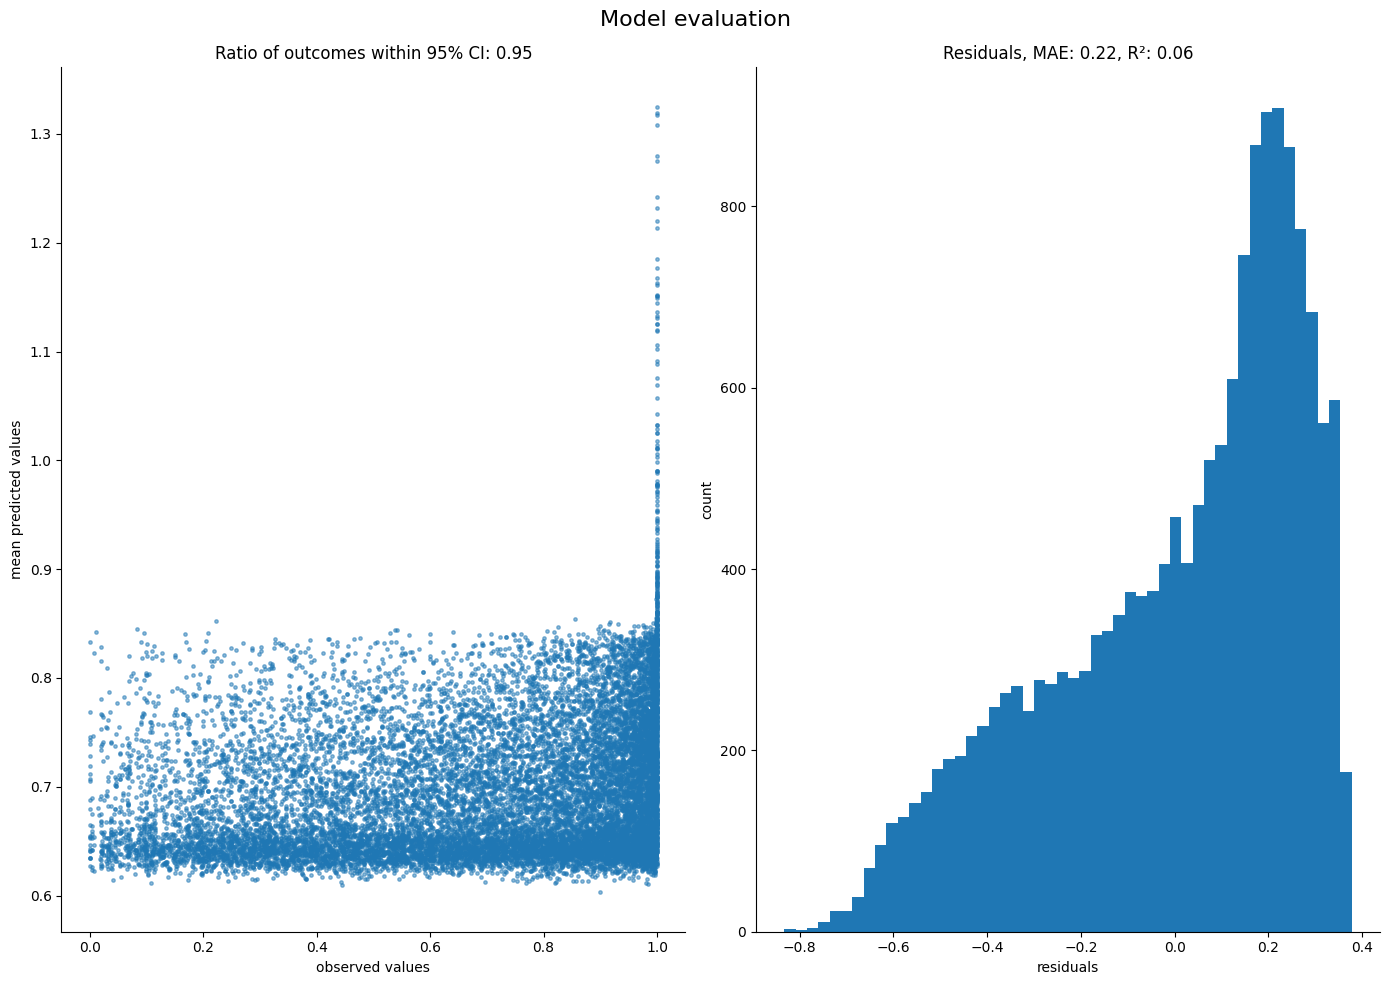

In [81]:
# the model explains some variance, but clearly there
# are many other things that guide the birds that this model does not capture
# perhaps some more work would be useful on the function form of the score, too

ft.evaluate_performance(
    model=ducks_model,
    guide=ducks_outcome["guide"],
    predictors=ducks_predictor_dict,
    outcome=ducks_outcome_dict,
    num_samples=1000,
)

In [82]:
sps_model = ft.HeteroskedasticLinear(sps_predictor_dict, sps_outcome_dict)

sps_outcome = ft.get_samples(
    model=sps_model,
    predictors=sps_predictor_dict,
    outcome=sps_outcome_dict,
    num_svi_iters=num_svi_iters,
    num_samples=num_samples,
    plot=False,
    verbose=False,
)

2024-10-18 10:23:36,212 - Starting SVI inference with 1000 iterations.


[iteration 0200] loss: 11552.9873
[iteration 0400] loss: 11564.1650
[iteration 0600] loss: 11545.8779
[iteration 0800] loss: 11535.8262


2024-10-18 10:23:45,282 - SVI inference completed in 9.07 seconds.


[iteration 1000] loss: 11533.7129
Coefficient marginals:
Site: weight_continuous_access_nextStep_sublinear_35
      mean       std        5%       25%       50%       75%      95%
0  0.39532  0.044937  0.320353  0.366387  0.396656  0.422541  0.46841 

Site: weight_continuous_proximity_nextStep_sublinear_35
       mean       std       5%       25%       50%       75%       95%
0 -0.037646  0.017106 -0.06529 -0.049208 -0.038406 -0.025668 -0.008743 



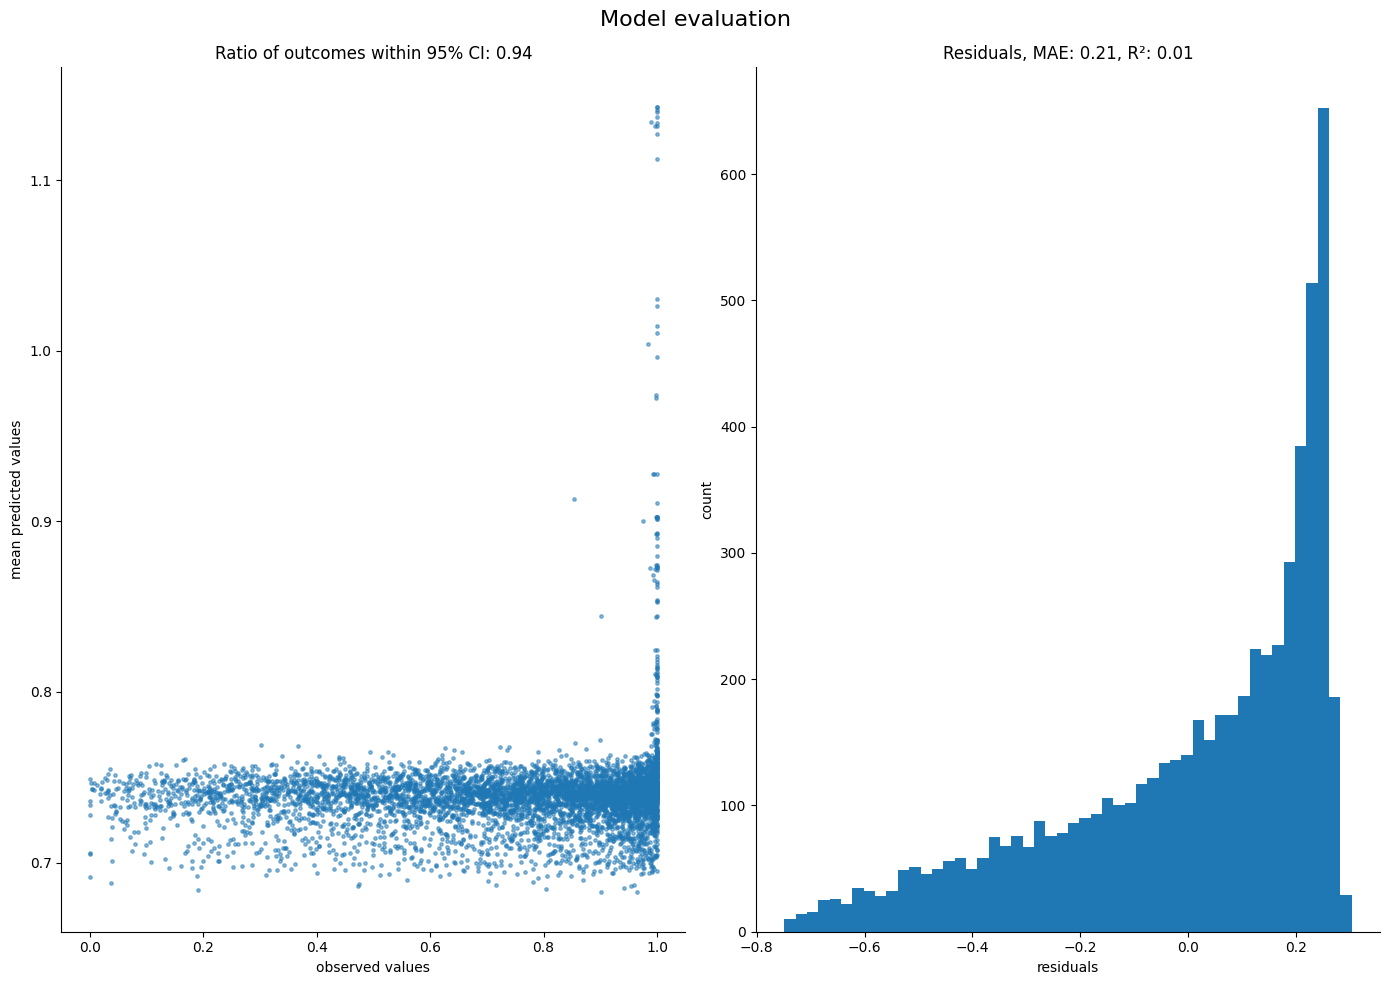

In [83]:
# not a great predictor,
# not a great model, as expected

ft.evaluate_performance(
    model=sps_model,
    guide=sps_outcome["guide"],
    predictors=sps_predictor_dict,
    outcome=sps_outcome_dict,
    num_samples=1000,
)

In [87]:
new_key = f"weight_continuous_proximity_{outcome_vars[0]}"
sites = {
    "ducks": ducks_outcome["samples"][new_key],
    "sparrows et al.": sps_outcome["samples"][new_key],
}

ft.plot_coefs(
    sites,
    "Posterior marginal for the proximity coefficients (both models)",
    nbins=120,
    ann_start_y=160,
    ann_break_y=50,
)